In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import jaccard_score
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

class SHAPExplainabilityAnalyzer:
    """
    Comprehensive SHAP explainability analysis tool for comparing centralized, 
    federated, and local model explanations.
    """
    
    def __init__(self):
        self.centralized_data = None
        self.federated_data = None
        self.local_clients_data = None
        self.feature_names = None
        self.results = {}
        
    def load_data(self, centralized_file: str, federated_file: str, local_clients_file: str):
        """Load SHAP data from JSON files"""
        try:
            with open(centralized_file, 'r') as f:
                self.centralized_data = json.load(f)
            with open(federated_file, 'r') as f:
                self.federated_data = json.load(f)
            with open(local_clients_file, 'r') as f:
                self.local_clients_data = json.load(f)
                
            print("✓ Data loaded successfully!")
            self._validate_data_structure()
            
        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
        except json.JSONDecodeError as e:
            print(f"Error: Invalid JSON format - {e}")
            
    def _validate_data_structure(self):
        """Validate the structure of loaded data"""
        # For your data format, centralized and federated are dictionaries of feature:importance
        if not isinstance(self.centralized_data, dict):
            raise ValueError("Centralized data should be a dictionary of feature:importance")
            
        if not isinstance(self.federated_data, dict):
            raise ValueError("Federated data should be a dictionary of feature:importance")
                
        # Check local clients data (should be a dictionary with client IDs as keys)
        if not isinstance(self.local_clients_data, dict):
            raise ValueError("Local clients data should be a dictionary with client IDs")
            
        # Extract feature names from centralized data
        self.feature_names = list(self.centralized_data.keys())
        
        # Validate that all models have the same features
        fed_features = set(self.federated_data.keys())
        cent_features = set(self.centralized_data.keys())
        
        if fed_features != cent_features:
            print("Warning: Federated and centralized models have different features")
            # Use intersection of features
            self.feature_names = list(cent_features.intersection(fed_features))
        
        # Check local clients
        n_clients = len(self.local_clients_data)
        for client_id, client_data in self.local_clients_data.items():
            if not isinstance(client_data, dict):
                raise ValueError(f"Client {client_id} data should be a dictionary")
        
        print(f"✓ Data validation passed! Found {len(self.feature_names)} features across {n_clients} clients")
    
    def compute_global_shap_vector(self, feature_importance_dict: Dict[str, float]) -> np.ndarray:
        """
        Convert feature importance dictionary to numpy array
        For your data format, we already have global importance values
        """
        # Create vector in consistent feature order
        vector = np.array([feature_importance_dict.get(feature, 0.0) for feature in self.feature_names])
        return vector
    
    def compute_alignment_metrics(self) -> Dict[str, Any]:
        """Compute alignment metrics between federated/local models and centralized baseline"""
        
        # Compute global SHAP vectors
        s_cent = self.compute_global_shap_vector(self.centralized_data)
        s_fed = self.compute_global_shap_vector(self.federated_data)
        
        # Compute local client vectors
        s_locals = []
        for client_id, client_data in self.local_clients_data.items():
            s_local = self.compute_global_shap_vector(client_data)
            s_locals.append(s_local)
        
        results = {
            'centralized_vector': s_cent,
            'federated_vector': s_fed,
            'local_vectors': s_locals,
            'client_ids': list(self.local_clients_data.keys()),
            'federated_metrics': {},
            'local_metrics': []
        }
        
        # Federated vs Centralized metrics
        results['federated_metrics'] = self._compute_similarity_metrics(s_fed, s_cent, 'Federated')
        
        # Local vs Centralized metrics (for each client)
        for i, (client_id, s_local) in enumerate(zip(self.local_clients_data.keys(), s_locals)):
            local_metrics = self._compute_similarity_metrics(s_local, s_cent, f'Local_Client_{client_id}')
            results['local_metrics'].append(local_metrics)
        
        return results
    
    def _compute_similarity_metrics(self, s_model: np.ndarray, s_cent: np.ndarray, model_name: str) -> Dict[str, float]:
        """Compute similarity metrics between model and centralized baseline"""
        
        # Spearman rank correlation
        spearman_corr, _ = spearmanr(s_model, s_cent)
        
        # Cosine similarity (1 - cosine distance)
        cosine_sim = 1 - cosine(s_model, s_cent)
        
        # Euclidean distance
        euclidean_dist = euclidean(s_model, s_cent)
        
        # Top-k feature overlap (Jaccard)
        jaccard_metrics = {}
        for k in [5, 10, 20]:
            if k <= len(s_model):
                top_k_model = set(np.argsort(s_model)[-k:])
                top_k_cent = set(np.argsort(s_cent)[-k:])
                intersection = len(top_k_model & top_k_cent)
                union = len(top_k_model | top_k_cent)
                jaccard_metrics[f'jaccard_top_{k}'] = intersection / union if union > 0 else 0
        
        return {
            'model_name': model_name,
            'spearman_correlation': spearman_corr,
            'cosine_similarity': cosine_sim,
            'euclidean_distance': euclidean_dist,
            **jaccard_metrics
        }
    
    def compute_stability_metrics(self, local_vectors: List[np.ndarray]) -> Dict[str, Any]:
        """Compute stability metrics across local clients"""
        
        # Stack local vectors for easier computation
        local_matrix = np.stack(local_vectors, axis=0)  # shape: (n_clients, n_features)
        
        # Compute variance across clients for each feature
        feature_variances = np.var(local_matrix, axis=0)
        
        # Overall stability metrics
        mean_variance = np.mean(feature_variances)
        max_variance = np.max(feature_variances)
        min_variance = np.min(feature_variances)
        
        return {
            'feature_variances': feature_variances,
            'mean_variance': mean_variance,
            'max_variance': max_variance,
            'min_variance': min_variance,
            'most_unstable_features': np.argsort(feature_variances)[-5:][::-1],  # Top 5 most unstable
            'most_stable_features': np.argsort(feature_variances)[:5]  # Top 5 most stable
        }
    
    def compute_instance_level_agreement(self, sample_size: int = 100) -> Dict[str, Any]:
        """
        Compute instance-level agreement metrics
        Note: Since your data contains global importance values rather than per-instance SHAP values,
        this method will compute feature-level agreement instead
        """
        
        # For your data format, we'll analyze feature-level agreements
        s_cent = self.compute_global_shap_vector(self.centralized_data)
        s_fed = self.compute_global_shap_vector(self.federated_data)
        
        # Federated vs Centralized feature-level metrics
        fed_distance = euclidean(s_fed, s_cent)
        fed_kendall_tau, _ = kendalltau(np.argsort(s_fed), np.argsort(s_cent))
        
        # Local clients vs Centralized feature-level metrics
        local_distances = []
        local_kendall_taus = []
        
        for client_id, client_data in self.local_clients_data.items():
            s_local = self.compute_global_shap_vector(client_data)
            
            distance = euclidean(s_local, s_cent)
            local_distances.append(distance)
            
            tau, _ = kendalltau(np.argsort(s_local), np.argsort(s_cent))
            local_kendall_taus.append(tau)
        
        return {
            'federated': {
                'mean_distance': fed_distance,
                'std_distance': 0.0,  # Single value
                'mean_kendall_tau': fed_kendall_tau,
                'std_kendall_tau': 0.0,  # Single value
                'distances': [fed_distance],
                'kendall_taus': [fed_kendall_tau]
            },
            'local_clients': {
                'mean_distances': local_distances,
                'mean_kendall_taus': local_kendall_taus,
                'all_distances': [local_distances],  # Wrapped for consistency
                'all_kendall_taus': [local_kendall_taus]  # Wrapped for consistency
            }
        }
    
    def run_complete_analysis(self, sample_size: int = 100) -> Dict[str, Any]:
        """Run the complete explainability analysis"""
        
        print("🔍 Starting SHAP explainability analysis...")
        
        # 1. Alignment with centralized benchmark
        print("  → Computing alignment metrics...")
        alignment_results = self.compute_alignment_metrics()
        
        # 2. Stability across clients
        print("  → Computing stability metrics...")
        stability_results = self.compute_stability_metrics(alignment_results['local_vectors'])
        
        # 3. Instance-level agreement
        print("  → Computing instance-level agreement...")
        instance_results = self.compute_instance_level_agreement(sample_size)
        
        # Compile all results
        self.results = {
            'alignment': alignment_results,
            'stability': stability_results,
            'instance_level': instance_results
        }
        
        print("✅ Analysis complete!")
        return self.results
    
    def generate_summary_report(self) -> str:
        """Generate a summary report of the analysis"""
        
        if not self.results:
            return "No analysis results available. Please run the analysis first."
        
        report = []
        report.append("=" * 60)
        report.append("SHAP EXPLAINABILITY ANALYSIS SUMMARY REPORT")
        report.append("=" * 60)
        
        # Alignment metrics summary
        report.append("\n📊 ALIGNMENT WITH CENTRALIZED BENCHMARK")
        report.append("-" * 40)
        
        fed_metrics = self.results['alignment']['federated_metrics']
        report.append(f"Federated Model:")
        report.append(f"  • Spearman Correlation: {fed_metrics['spearman_correlation']:.4f}")
        report.append(f"  • Cosine Similarity: {fed_metrics['cosine_similarity']:.4f}")
        report.append(f"  • Euclidean Distance: {fed_metrics['euclidean_distance']:.4f}")
        
        for k in [5, 10, 20]:
            key = f'jaccard_top_{k}'
            if key in fed_metrics:
                report.append(f"  • Top-{k} Jaccard: {fed_metrics[key]:.4f}")
        
        # Local clients summary
        local_metrics = self.results['alignment']['local_metrics']
        spearman_scores = [m['spearman_correlation'] for m in local_metrics]
        cosine_scores = [m['cosine_similarity'] for m in local_metrics]
        
        report.append(f"\nLocal Models (across {len(local_metrics)} clients):")
        report.append(f"  • Spearman Correlation - Mean: {np.mean(spearman_scores):.4f} (±{np.std(spearman_scores):.4f})")
        report.append(f"  • Cosine Similarity - Mean: {np.mean(cosine_scores):.4f} (±{np.std(cosine_scores):.4f})")
        
        # Stability metrics summary
        report.append("\n🎯 STABILITY ACROSS CLIENTS")
        report.append("-" * 30)
        stability = self.results['stability']
        report.append(f"Feature Importance Variance:")
        report.append(f"  • Mean: {stability['mean_variance']:.6f}")
        report.append(f"  • Range: [{stability['min_variance']:.6f}, {stability['max_variance']:.6f}]")
        
        # Most unstable features
        unstable_indices = stability['most_unstable_features']
        report.append(f"  • Most Unstable Features:")
        for i, idx in enumerate(unstable_indices):
            if idx < len(self.feature_names):
                report.append(f"    {i+1}. {self.feature_names[idx]} (var: {stability['feature_variances'][idx]:.6f})")
        
        # Instance-level agreement summary
        report.append("\n🔍 INSTANCE-LEVEL AGREEMENT")
        report.append("-" * 30)
        instance = self.results['instance_level']
        
        report.append(f"Federated vs Centralized:")
        report.append(f"  • Mean Distance: {instance['federated']['mean_distance']:.4f}")
        report.append(f"  • Mean Kendall-τ: {instance['federated']['mean_kendall_tau']:.4f}")
        
        local_mean_distances = instance['local_clients']['mean_distances']
        local_mean_taus = instance['local_clients']['mean_kendall_taus']
        
        report.append(f"Local vs Centralized:")
        report.append(f"  • Mean Distance: {np.mean(local_mean_distances):.4f} (±{np.std(local_mean_distances):.4f})")
        report.append(f"  • Mean Kendall-τ: {np.mean(local_mean_taus):.4f} (±{np.std(local_mean_taus):.4f})")
        
        report.append("\n" + "=" * 60)
        
        return "\n".join(report)
    
    def create_visualizations(self, save_plots: bool = True, output_dir: str = ""):
        """Create all required visualizations as separate plots"""
        
        if not self.results:
            print("No results available. Please run the analysis first.")
            return
        
        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
        plot_funcs = [
            (self._plot_feature_importance_heatmap, "1_feature_importance_heatmap.png", "Feature Importance Heatmap"),
            (self._plot_topk_features, "2_topk_features.png", "Top-K Feature Comparison"),
            (self._plot_correlation_matrix, "3_correlation_matrix.png", "Correlation Matrix"),
            (self._plot_stability_boxplot, "4_stability_boxplot.png", "Stability Across Clients"),
            (self._plot_instance_distances, "5_instance_distances.png", "Instance-Level Distances"),
            (self._plot_rank_agreement, "6_rank_agreement.png", "Rank Agreement"),
            (self._plot_alignment_metrics, "7_alignment_metrics.png", "Alignment Metrics"),
            (self._plot_feature_variance_distribution, "8_feature_variance_dist.png", "Feature Variance Distribution"),
            (self._plot_summary_radar, "9_summary_radar.png", "Summary Performance Radar")
        ]
        
        created_plots = []
        
        for plot_func, filename, title in plot_funcs:
            try:
                # Create figure with appropriate size
                if "radar" in filename:
                    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
                else:
                    fig, ax = plt.subplots(figsize=(12, 8))
                
                # Create the plot
                if "topk" in filename:
                    plot_func(ax, k=10)  # Pass k parameter for top-k plot
                else:
                    plot_func(ax)
                
                # Adjust layout
                plt.tight_layout()
                
                # Save if requested
                if save_plots:
                    full_path = f"{output_dir}{filename}" if output_dir else filename
                    plt.savefig(full_path, dpi=300, bbox_inches='tight')
                    created_plots.append(full_path)
                    print(f"📊 Saved: {full_path}")
                
                # Show the plot
                plt.show()
                
                # Close the figure to free memory
                plt.close(fig)
                
            except Exception as e:
                print(f"Error creating plot {title}: {e}")
        
        if save_plots and created_plots:
            print(f"\n✅ Created {len(created_plots)} individual plots!")
            return created_plots
    
    def _plot_feature_importance_heatmap(self, ax):
        """Plot feature importance heatmap across paradigms"""
        
        # Prepare data for heatmap
        s_cent = self.results['alignment']['centralized_vector']
        s_fed = self.results['alignment']['federated_vector']
        local_vectors = self.results['alignment']['local_vectors']
        
        # Create matrix with top features only (for readability)
        top_k = min(20, len(s_cent))
        top_indices = np.argsort(s_cent)[-top_k:]
        
        heatmap_data = []
        heatmap_data.append(s_cent[top_indices])
        heatmap_data.append(s_fed[top_indices])
        
        # Add mean local importance
        mean_local = np.mean(local_vectors, axis=0)
        heatmap_data.append(mean_local[top_indices])
        
        heatmap_matrix = np.array(heatmap_data)
        
        # Create feature labels
        feature_labels = [self.feature_names[i] if i < len(self.feature_names) 
                         else f'Feature_{i}' for i in top_indices]
        
        sns.heatmap(heatmap_matrix, 
                   xticklabels=feature_labels,
                   yticklabels=['Centralized', 'Federated', 'Local (Mean)'],
                   annot=False, cmap='YlOrRd', ax=ax)
        
        ax.set_title(f'Feature Importance Heatmap (Top {top_k})', fontsize=16, pad=20)
        ax.set_xlabel('Features', fontsize=12)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    def _plot_topk_features(self, ax, k=10):
        """Plot top-k features comparison"""
        
        s_cent = self.results['alignment']['centralized_vector']
        s_fed = self.results['alignment']['federated_vector']
        local_vectors = self.results['alignment']['local_vectors']
        mean_local = np.mean(local_vectors, axis=0)
        
        # Get top-k features from centralized model
        top_k_indices = np.argsort(s_cent)[-k:][::-1]
        
        x_pos = np.arange(k)
        width = 0.25
        
        cent_values = s_cent[top_k_indices]
        fed_values = s_fed[top_k_indices]
        local_values = mean_local[top_k_indices]
        
        ax.bar(x_pos - width, cent_values, width, label='Centralized', alpha=0.8)
        ax.bar(x_pos, fed_values, width, label='Federated', alpha=0.8)
        ax.bar(x_pos + width, local_values, width, label='Local (Mean)', alpha=0.8)
        
        # Feature labels
        feature_labels = [self.feature_names[i] if i < len(self.feature_names) 
                         else f'F{i}' for i in top_k_indices]
        
        ax.set_xlabel('Features', fontsize=12)
        ax.set_ylabel('SHAP Importance', fontsize=12)
        ax.set_title(f'Top-{k} Feature Comparison', fontsize=16, pad=20)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(feature_labels, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_correlation_matrix(self, ax):
        """Plot correlation matrix between models"""
        
        # Compute correlation matrix
        s_cent = self.results['alignment']['centralized_vector']
        s_fed = self.results['alignment']['federated_vector']
        local_vectors = self.results['alignment']['local_vectors']
        
        # Create data matrix
        all_vectors = [s_cent, s_fed] + local_vectors
        labels = ['Centralized', 'Federated'] + [f'Local_{i}' for i in range(len(local_vectors))]
        
        # Compute correlation matrix
        corr_matrix = np.corrcoef(all_vectors)
        
        # Plot only a subset if too many clients
        if len(labels) > 8:
            # Show centralized, federated, and first 6 local clients
            subset_indices = [0, 1] + list(range(2, min(8, len(labels))))
            corr_matrix = corr_matrix[np.ix_(subset_indices, subset_indices)]
            labels = [labels[i] for i in subset_indices]
        
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', 
                   xticklabels=labels, yticklabels=labels,
                   cmap='RdBu_r', center=0, ax=ax)
        
        ax.set_title('Feature Importance Correlation Matrix', fontsize=16, pad=20)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    def _plot_stability_boxplot(self, ax):
        """Plot stability across clients"""
        
        stability = self.results['stability']
        feature_vars = stability['feature_variances']
        
        # Create boxplot of feature variances
        ax.boxplot([feature_vars], labels=['Feature Variances'])
        ax.set_ylabel('Variance', fontsize=12)
        ax.set_title('Stability Across Clients', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
        
        # Add summary statistics as text
        mean_var = stability['mean_variance']
        ax.text(0.7, 0.9, f'Mean: {mean_var:.6f}', transform=ax.transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    def _plot_instance_distances(self, ax):
        """Plot feature-level distance distributions"""
        
        instance = self.results['instance_level']
        
        fed_distances = instance['federated']['distances']
        local_distances = instance['local_clients']['mean_distances']
        
        # Create data for boxplot
        all_data = [fed_distances, local_distances]
        labels = ['Federated', 'Local (All)']
        
        ax.boxplot(all_data, labels=labels)
        ax.set_ylabel('Euclidean Distance', fontsize=12)
        ax.set_title('Feature-level SHAP Vector Distances', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
    
    def _plot_rank_agreement(self, ax):
        """Plot rank agreement distributions"""
        
        instance = self.results['instance_level']
        
        fed_taus = instance['federated']['kendall_taus']
        local_taus = instance['local_clients']['mean_kendall_taus']
        
        # Create data for boxplot
        all_data = [fed_taus, local_taus]
        labels = ['Federated', 'Local (All)']
        
        ax.boxplot(all_data, labels=labels)
        ax.set_ylabel('Kendall-τ', fontsize=12)
        ax.set_title('Feature-level Rank Agreement', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
    
    def _plot_alignment_metrics(self, ax):
        """Plot alignment metrics comparison"""
        
        fed_metrics = self.results['alignment']['federated_metrics']
        local_metrics = self.results['alignment']['local_metrics']
        
        # Compute means for local metrics
        local_spearman = np.mean([m['spearman_correlation'] for m in local_metrics])
        local_cosine = np.mean([m['cosine_similarity'] for m in local_metrics])
        
        metrics = ['Spearman ρ', 'Cosine Sim']
        fed_values = [fed_metrics['spearman_correlation'], fed_metrics['cosine_similarity']]
        local_values = [local_spearman, local_cosine]
        
        x_pos = np.arange(len(metrics))
        width = 0.35
        
        ax.bar(x_pos - width/2, fed_values, width, label='Federated', alpha=0.8)
        ax.bar(x_pos + width/2, local_values, width, label='Local (Mean)', alpha=0.8)
        
        ax.set_xlabel('Metrics', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Alignment with Centralized Model', fontsize=16, pad=20)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_feature_variance_distribution(self, ax):
        """Plot distribution of feature variances"""
        
        stability = self.results['stability']
        feature_vars = stability['feature_variances']
        
        ax.hist(feature_vars, bins=20, alpha=0.7, edgecolor='black')
        ax.axvline(stability['mean_variance'], color='red', linestyle='--', 
                  label=f'Mean: {stability["mean_variance"]:.6f}')
        ax.set_xlabel('Feature Variance', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('Distribution of Feature Variances', fontsize=16, pad=20)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_summary_radar(self, ax):
        """Plot summary radar chart"""
        
        # Normalize metrics for radar chart
        fed_metrics = self.results['alignment']['federated_metrics']
        local_metrics = self.results['alignment']['local_metrics']
        stability = self.results['stability']
        instance = self.results['instance_level']
        
        # Define metrics and their values
        categories = ['Spearman ρ', 'Cosine Sim', 'Stability\n(1-variance)', 'Rank Agree', 'Distance\n(1-norm)']
        
        # Federated values (normalized to 0-1)
        fed_spearman = (fed_metrics['spearman_correlation'] + 1) / 2
        fed_cosine = (fed_metrics['cosine_similarity'] + 1) / 2
        fed_stability = 1 - min(stability['mean_variance'] / stability['max_variance'], 1)
        fed_rank = (instance['federated']['mean_kendall_tau'] + 1) / 2
        fed_distance = 1 - min(instance['federated']['mean_distance'] / 10, 1)
        
        fed_values = [fed_spearman, fed_cosine, fed_stability, fed_rank, fed_distance]
        
        # Local mean values
        local_spearman = np.mean([(m['spearman_correlation'] + 1) / 2 for m in local_metrics])
        local_cosine = np.mean([(m['cosine_similarity'] + 1) / 2 for m in local_metrics])
        local_rank = np.mean([(tau + 1) / 2 for tau in instance['local_clients']['mean_kendall_taus']])
        local_distance = 1 - np.mean([min(dist / 10, 1) for dist in instance['local_clients']['mean_distances']])
        
        local_values = [local_spearman, local_cosine, fed_stability, local_rank, local_distance]
        
        # Angles for radar chart
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]
        
        fed_values += fed_values[:1]
        local_values += local_values[:1]
        
        ax.plot(angles, fed_values, 'o-', linewidth=2, label='Federated', alpha=0.8)
        ax.fill(angles, fed_values, alpha=0.25)
        ax.plot(angles, local_values, 's-', linewidth=2, label='Local (Mean)', alpha=0.8)
        ax.fill(angles, local_values, alpha=0.25)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_title('Summary Performance Radar', fontsize=16, pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        ax.grid(True)


Loading SHAP data...
Your JSON files should have the following structure:
- Centralized/Federated: Dictionary with feature names as keys and importance values
- Local clients: Dictionary with client IDs as keys, each containing feature:importance dict

Expected files:
- center.json
- fl.json
- fl_clients.json

✓ Data loaded successfully!
✓ Data validation passed! Found 10 features across 10 clients
🔍 Starting SHAP explainability analysis...
  → Computing alignment metrics...
  → Computing stability metrics...
  → Computing instance-level agreement...
✅ Analysis complete!
SHAP EXPLAINABILITY ANALYSIS SUMMARY REPORT

📊 ALIGNMENT WITH CENTRALIZED BENCHMARK
----------------------------------------
Federated Model:
  • Spearman Correlation: 0.5030
  • Cosine Similarity: 0.8794
  • Euclidean Distance: 10.6516
  • Top-5 Jaccard: 0.6667
  • Top-10 Jaccard: 1.0000

Local Models (across 10 clients):
  • Spearman Correlation - Mean: 0.4586 (±0.2480)
  • Cosine Similarity - Mean: 0.8031 (±0.1433)


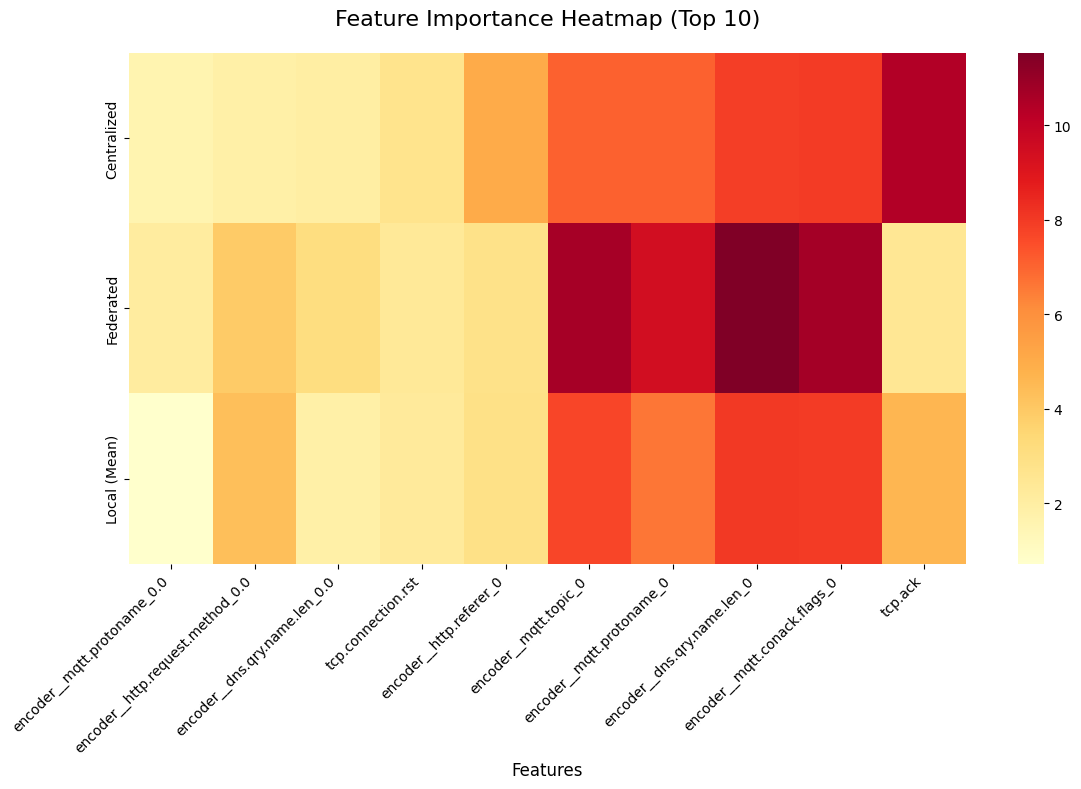

📊 Saved: 2_topk_features.png


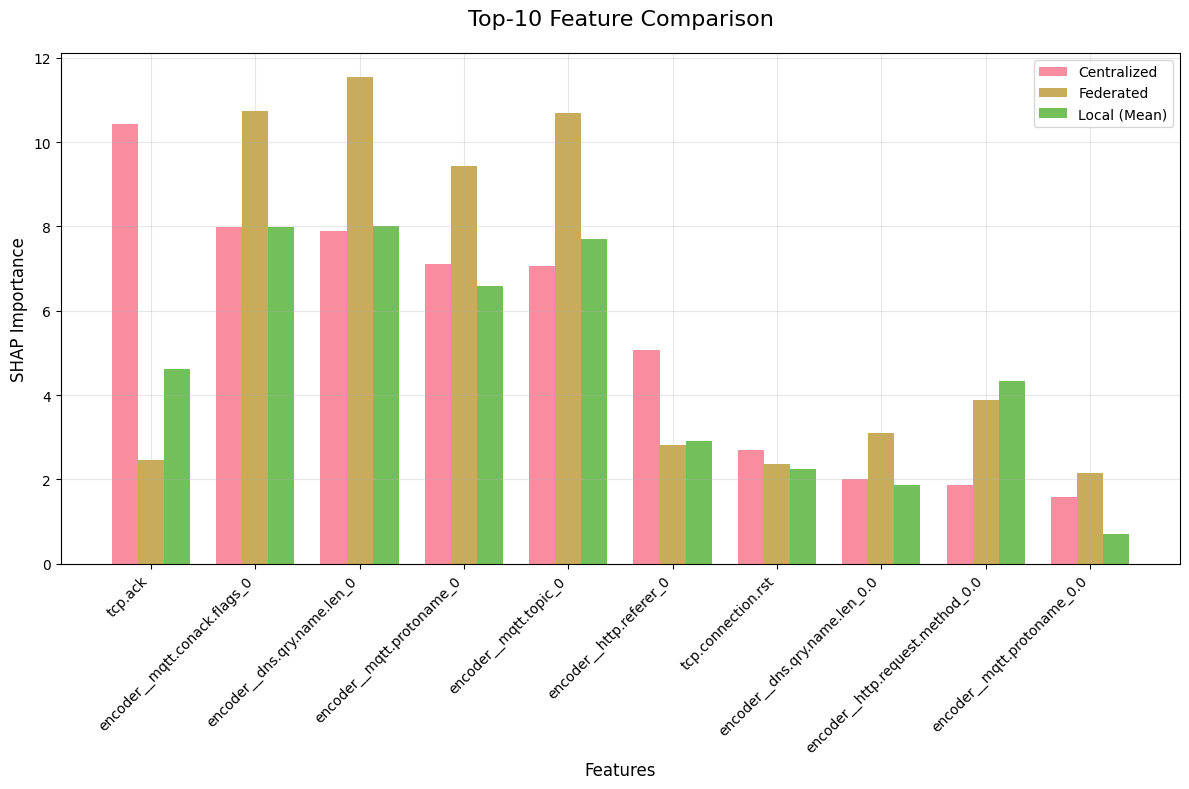

📊 Saved: 3_correlation_matrix.png


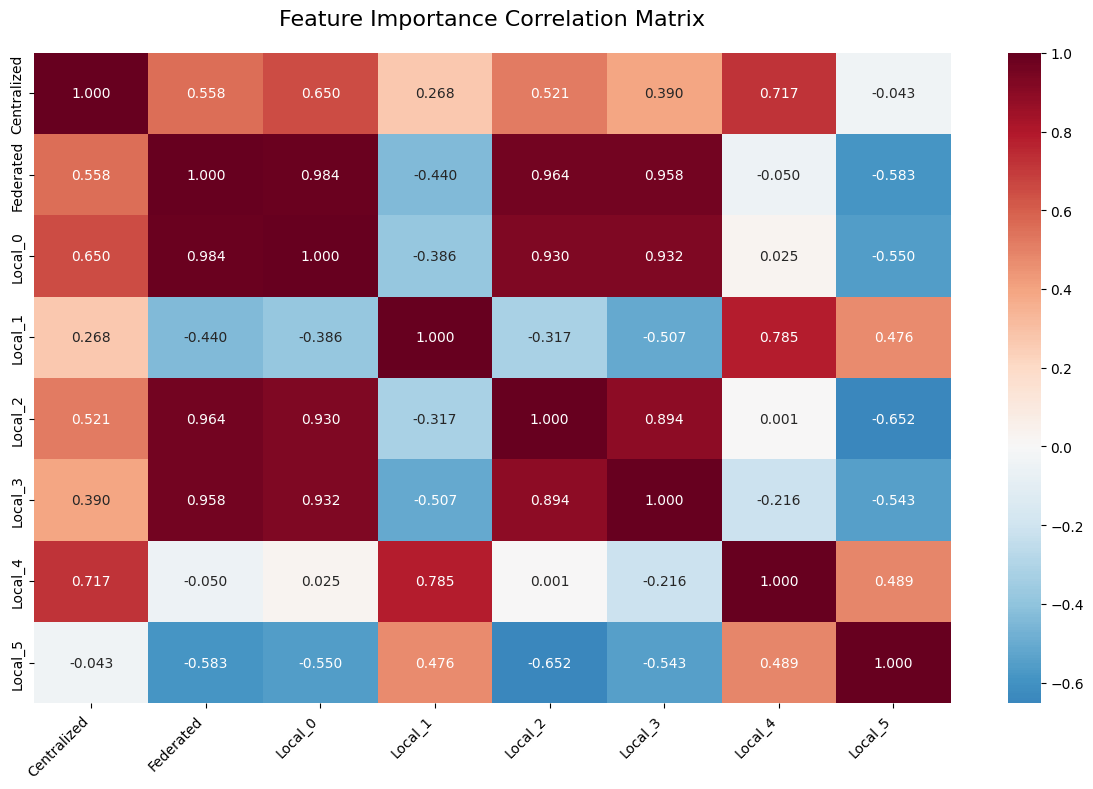

📊 Saved: 4_stability_boxplot.png


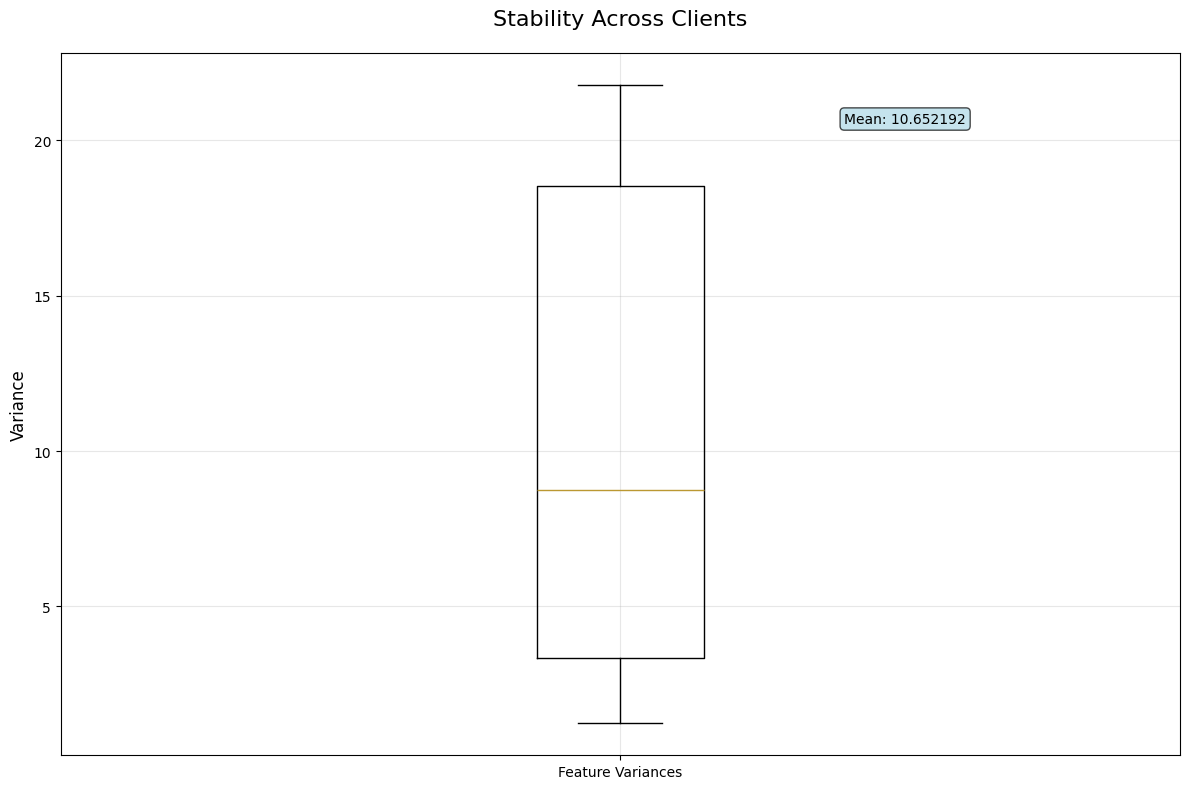

📊 Saved: 5_instance_distances.png


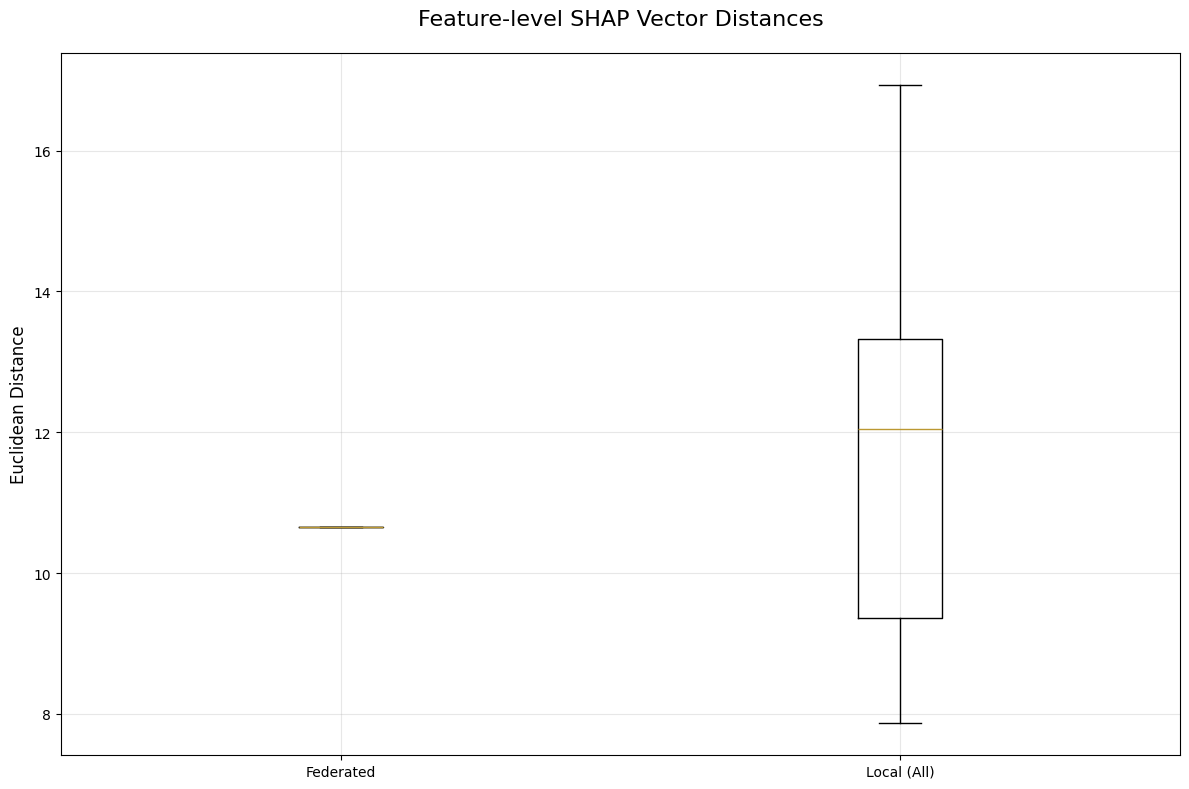

📊 Saved: 6_rank_agreement.png


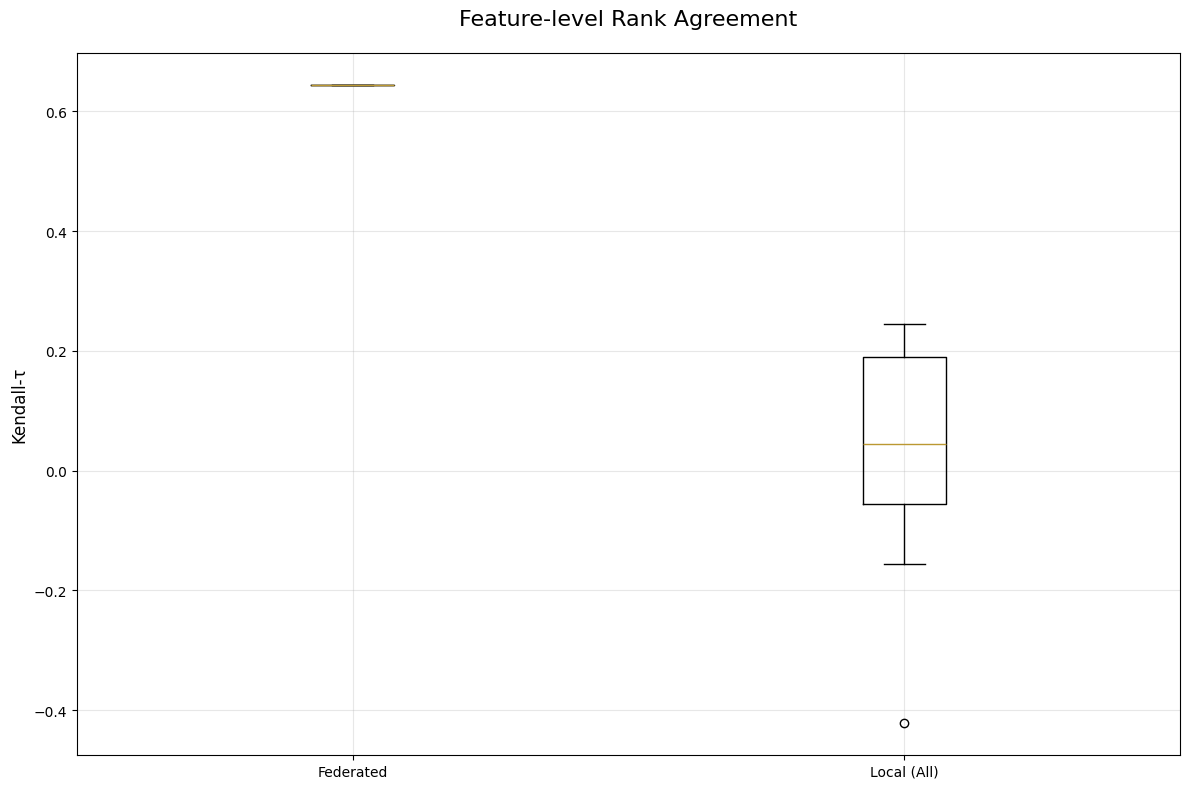

📊 Saved: 7_alignment_metrics.png


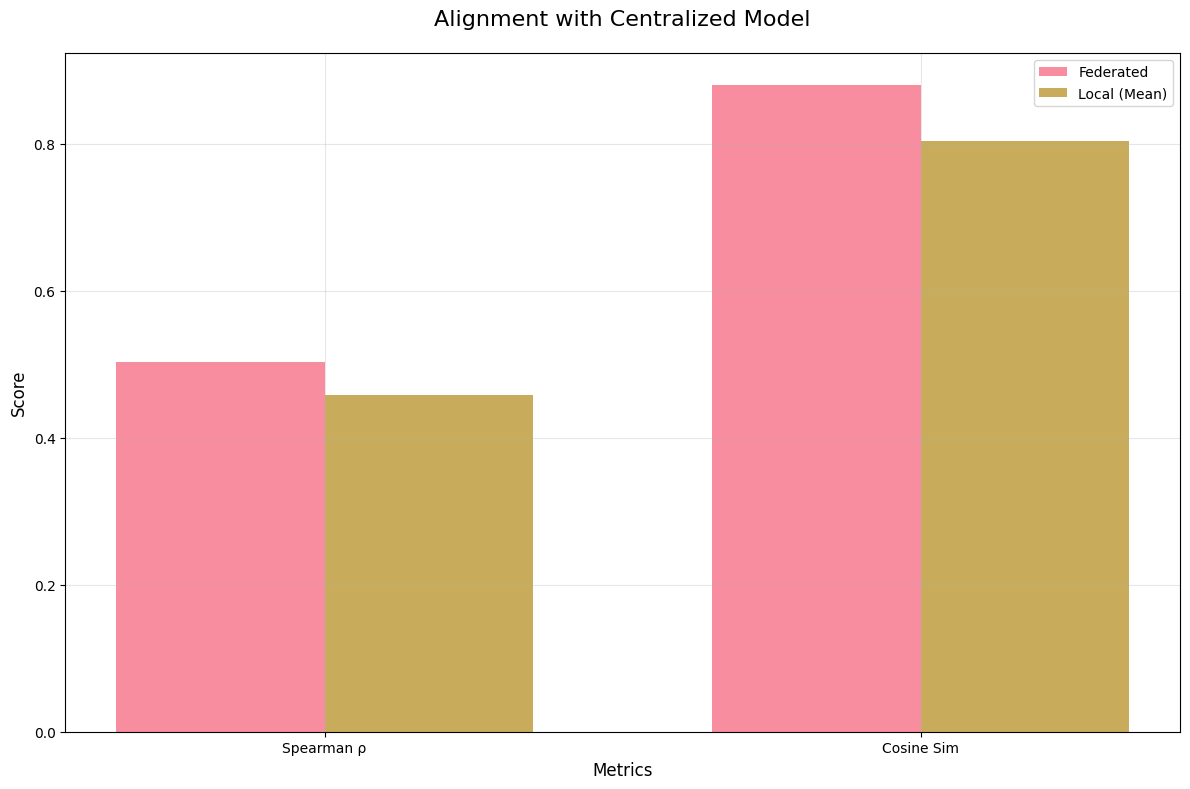

📊 Saved: 8_feature_variance_dist.png


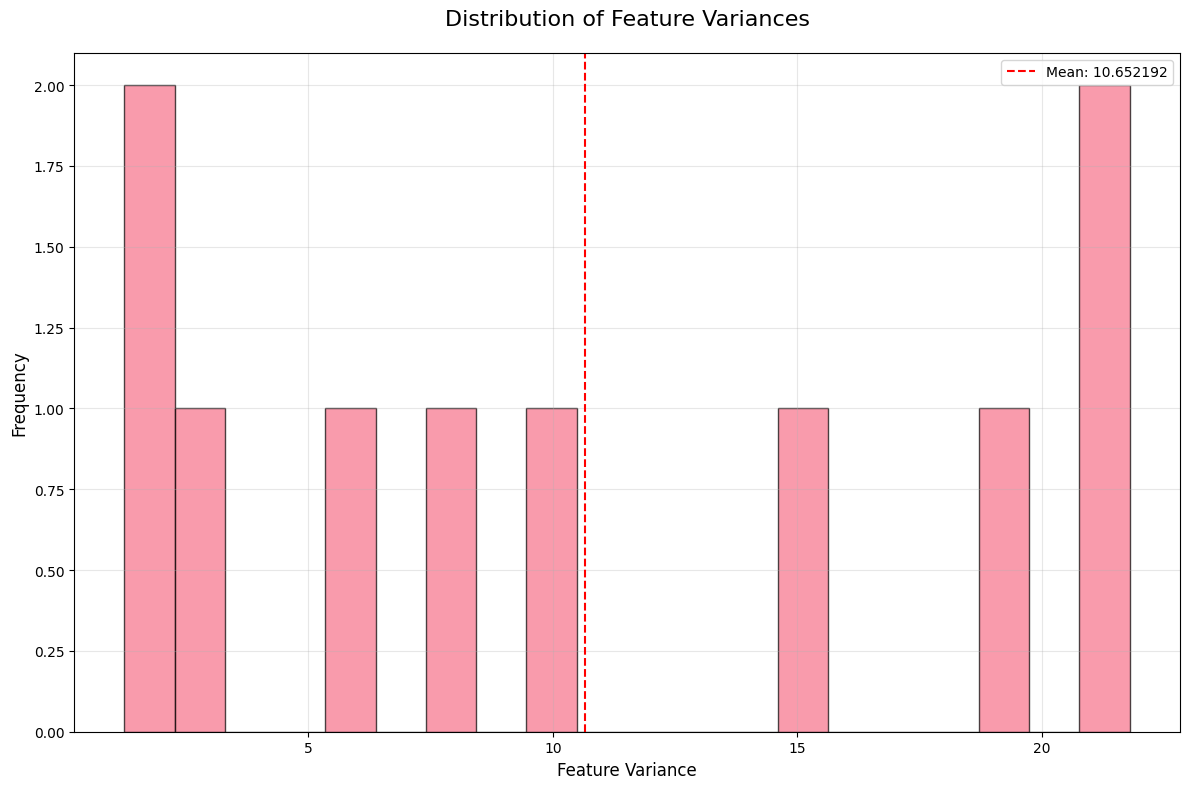

📊 Saved: 9_summary_radar.png


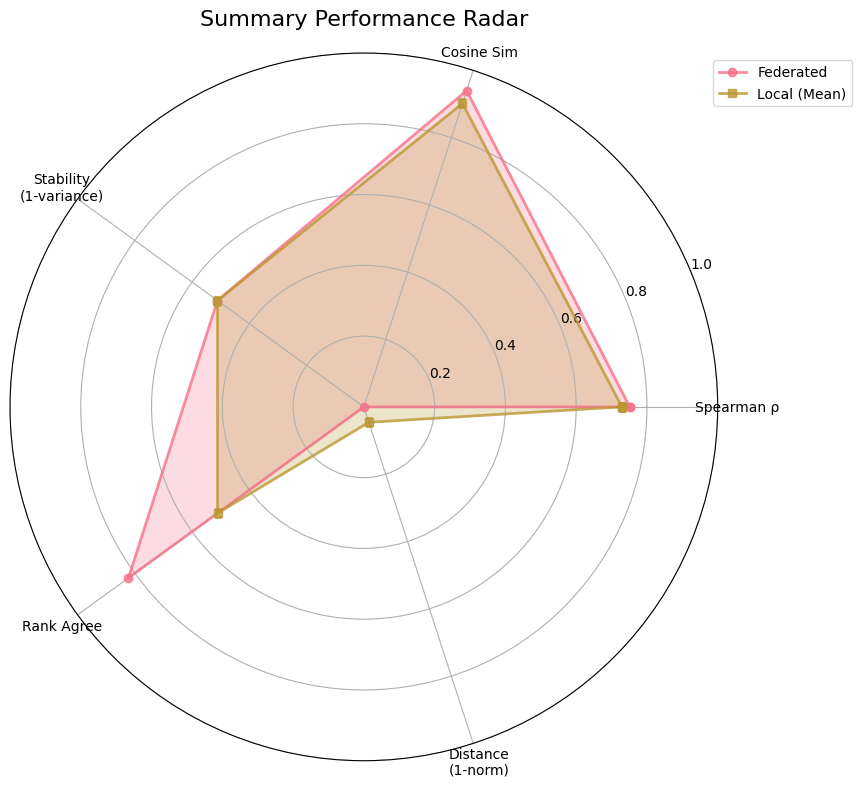


✅ Created 9 individual plots!
📁 Detailed results saved to 'detailed_analysis_results.json'


In [14]:
# Initialize analyzer
analyzer = SHAPExplainabilityAnalyzer()

# Load data (replace with your actual file paths)
print("Loading SHAP data...")
print("Your JSON files should have the following structure:")
print("- Centralized/Federated: Dictionary with feature names as keys and importance values")
print("- Local clients: Dictionary with client IDs as keys, each containing feature:importance dict")
print()

# Example file paths (replace with your actual paths)
centralized_file = "center.json"
federated_file = "fl.json" 
local_clients_file = "fl_clients.json"

print(f"Expected files:")
print(f"- {centralized_file}")
print(f"- {federated_file}")
print(f"- {local_clients_file}")
print()

try:
    # Load the data
    analyzer.load_data(centralized_file, federated_file, local_clients_file)
    
    # Run complete analysis
    results = analyzer.run_complete_analysis()
    
    # Generate and print summary report
    report = analyzer.generate_summary_report()
    print(report)
    
    # Create visualizations
    analyzer.create_visualizations(save_plots=True)
    
    # Save detailed results to JSON
    with open('detailed_analysis_results.json', 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        results_serializable = {}
        for key, value in results.items():
            if key == 'alignment':
                results_serializable[key] = {
                    'federated_metrics': value['federated_metrics'],
                    'local_metrics': value['local_metrics'],
                    # Convert numpy arrays to lists
                    'centralized_vector': value['centralized_vector'].tolist(),
                    'federated_vector': value['federated_vector'].tolist(),
                    'local_vectors': [v.tolist() for v in value['local_vectors']],
                    'client_ids': value.get('client_ids', [])
                }
            elif key == 'stability':
                results_serializable[key] = {
                    'feature_variances': value['feature_variances'].tolist(),
                    'mean_variance': value['mean_variance'],
                    'max_variance': value['max_variance'],
                    'min_variance': value['min_variance'],
                    'most_unstable_features': value['most_unstable_features'].tolist(),
                    'most_stable_features': value['most_stable_features'].tolist()
                }
            else:
                results_serializable[key] = value
        
        json.dump(results_serializable, f, indent=2)
    print("📁 Detailed results saved to 'detailed_analysis_results.json'")
    
except Exception as e:
    print(f"❌ Error during analysis: {e}")
    print("\nPlease ensure your JSON files match the expected format:")
    print("Example centralized_shap.json:")
    print('{"feature1": 10.5, "feature2": 8.3, ...}')
    print("\nExample local_clients_shap.json:")
    print('{"0": {"feature1": 9.2, "feature2": 7.8, ...}, "1": {...}, ...}')